<a href="https://colab.research.google.com/github/AjayKumarGogineni777/Lung-Cancer-Classfication/blob/master/PreTrained3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#### 2D CNN for lung cancer classification 
import fastai
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.resnet import inceptionv4
from fastai.models.resnet import resnext_50_32x4d
from fastai.model import *

import json
import sklearn
from  sklearn.metrics import cohen_kappa_score
# !pip install tifffile
# import tifffile
from skimage import io

In [0]:
#np.random.seed(42)
path2 = '/content/gdrive/My Drive/Cancer/data3/'
data = ImageDataBunch.from_folder(path2, train="train",valid='valid', valid_pct=None,
        ds_tfms=get_transforms(), size=50, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['neg', 'pos'], 2, 5187, 1297)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
image_size = 50 
train_data_dir = path2+'train'
validation_data_dir = path2+'valid'
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        classes=['neg','pos'],
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        classes=['neg','pos'],
        target_size=(50, 50),
        batch_size=16,
        class_mode='binary')
 
#validation_generator = validation_datagen.flow_from_directory(
 #       path2+'valid',
 #       target_size=(image_size, image_size),
  #      batch_size=val_batchsize,
   #     class_mode='binary',
    #    shuffle=False)

Found 5187 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet',include_top=False)

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size)

Epoch 1/10


In [0]:
import tensorflow as tf
opt_fn = tf.train.AdamOptimizer

loss_fn = tf.losses.sparse_softmax_cross_entropy
learn = TfLearner(data, model, opt_fn, loss_fn, metrics=accuracy)

In [0]:
#import torchvision.models as models
#resnet18 = models.resnet18()
#alexnet = models.alexnet()
#vgg16 = models.vgg16()
#squeezenet = models.squeezenet1_0()
#densenet = models.densenet161()
#inception = models.inception_v3()

In [0]:
import torchvision.models as models2
resnet18 = models2.resnet18(pretrained=True)
alexnet = models2.alexnet(pretrained=True)
squeezenet = models2.squeezenet1_0(pretrained=True)
vgg16 = models2.vgg16(pretrained=True)
densenet = models2.densenet161(pretrained=True)
inception = models2.inception_v3(pretrained=True)

In [0]:
def hinge(y_true, y_pred):
    zero = torch.Tensor([0]) 
    return torch.sum(torch.max(zero, 0.5 - y_true * y_pred) ** 2)

In [0]:
def weighted_mse_loss(input,target):
    #alpha of 0.5 means half weight goes to first, remaining half split by remaining 15
    weights = Variable(torch.Tensor([0.5,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15,0.5/15])).cuda()  
    pct_var = (input-target)**2
    out = pct_var * weights.expand_as(target)
    loss = out.mean() 
    return loss

In [0]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [0]:
### Loavsz Hinge loss
##  helper function : MEAN
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n
  
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
  
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


In [0]:
import torch.nn as nn
import torch.nn.functional as F


In [0]:
#arch = models.darknet53
#arch = vgg16
learn = create_cnn(data, model23, metrics=error_rate)
#learn.crit = lovasz_hinge
#learn.crit = weighted_mse_loss
#learn.crit = nn.BCELoss()

In [0]:
#w = torch.cuda.FloatTensor([1.0, 0.9, 1.1])
#learn = create_cnn(data, models.resnet18, metrics = error_rate, loss_func=torch.nn.CrossEntropyLoss(weight=w))
#learn.fit_one_cycle(1, 0.001)

In [0]:
#w = torch.cuda.FloatTensor([1.0, 0.9, 1.1])
#learn = create_cnn(data, models2.densenet161, metrics = error_rate)

In [0]:
learn.fit_one_cycle(3)

In [0]:
learn.save('stage-1-inception_v3')

In [0]:
learn.load('stage-1-inception_v3')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


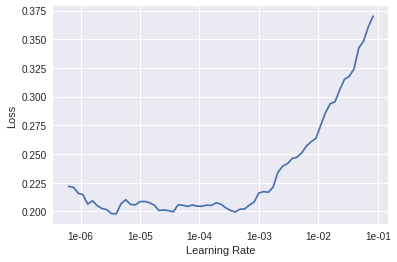

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
1,0.189555,0.190692,0.062452,00:46
2,0.168761,0.179658,0.051658,00:46
3,0.128658,0.136615,0.047803,00:46
4,0.085604,0.130794,0.049345,00:46
5,0.062793,0.128444,0.046261,00:46
6,0.055126,0.128371,0.044719,00:45


In [0]:
learn.save('stage-2-inception_v3')

In [0]:
learn.load('stage-2-inception_v3');

In [0]:
import imageio as io
train_dir = '/content/gdrive/My Drive/Cancer/data3/2D_fastai_1/train/pos'
i1 = io.imread(train_dir+'/107.tif')
i2 = io.imread(train_dir+'/1071.tif')
import tensorflow as tf
k1 = tf.stack([i1, i2], axis=-1)

In [0]:
a1 = learn.predict(i1)

In [0]:
learn.fit_one_cycle(6, max_lr=slice(4e-4,4e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.138866,2.426551,0.242868,00:46
2,0.173774,0.316760,0.092521,00:46
3,0.164943,0.142464,0.054742,00:46
4,0.121328,0.103035,0.033924,00:45
5,0.092144,0.090671,0.027756,00:46
6,0.066915,0.087896,0.031611,00:46


In [0]:
learn.save('stage-3-inception_v3')

In [0]:
learn.Precompute = 'False'


In [0]:
#learn.load('stage-3-vgg16')

In [0]:
import pandas as pd

In [0]:
preds,y,losses = learn.get_preds(with_loss = True)

In [0]:
preds

tensor([[1.1757e-02, 9.8824e-01],
        [5.6446e-07, 1.0000e+00],
        [3.6137e-01, 6.3863e-01],
        ...,
        [9.9954e-01, 4.6334e-04],
        [9.9888e-01, 1.1241e-03],
        [9.9931e-01, 6.9217e-04]])

In [0]:
y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [0]:
import tensorflow as tf

In [0]:
sess = tf.Session()

In [0]:
with sess.as_default():
  tensor = tf.constant(preds)
  npa = tensor.eval()
  t2 = tf.constant(y)
  y_array = t2.eval()

In [0]:
npa

array([[1.175671e-02, 9.882433e-01],
       [5.644562e-07, 9.999994e-01],
       [3.613720e-01, 6.386279e-01],
       [2.943840e-03, 9.970561e-01],
       ...,
       [9.420600e-01, 5.794002e-02],
       [9.995366e-01, 4.633366e-04],
       [9.988759e-01, 1.124129e-03],
       [9.993079e-01, 6.921735e-04]], dtype=float32)

In [0]:
k1 = preds.eval()

In [0]:
ds = pd.DataFrame(npa)
ds.columns = data.classes

In [0]:
data.classes

['neg', 'pos']

In [0]:
ds.head()

,neg,pos
0,1.175671e-02,0.988243
1,5.644562e-07,0.999999
2,3.613720e-01,0.638628
3,2.943840e-03,0.997056
4,3.864958e-04,0.999614


In [0]:
y_array

array([1, 1, 1, 1, ..., 0, 0, 0, 0])

In [0]:
ds.to_csv('/content/gdrive/My Drive/Cancer/outputs_new/densenet.csv')

In [0]:
#y_array.to_csv('/content/gdrive/My Drive/Cancer/outputs_new/labels_densenet.csv')

pd.DataFrame(y_array).to_csv('/content/gdrive/My Drive/Cancer/outputs_new/original_labels_densenet.csv')

In [0]:
learn.fit_one_cycle(8, max_lr=slice(4e-4,3e-3))

epoch,train_loss,valid_loss,error_rate
1,0.152037,0.163035,0.059368
2,0.173245,0.291801,0.097918
3,0.176515,0.191296,0.074788
4,0.165590,0.155604,0.055513
5,0.154066,0.263169,0.083269
6,0.139251,0.159030,0.060910
7,0.111252,0.125425,0.043948
8,0.105864,0.130729,0.045490


In [0]:
learn.save('stage-4-squeezenet')

In [0]:
learn.load('stage-4-squeezenet')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5187 items)
[Category neg, Category neg, Category neg, Category neg, Category neg]...
Path: /content/gdrive/My Drive/Cancer/data3
x: ImageItemList (5187 items)
[Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50)]...
Path: /content/gdrive/My Drive/Cancer/data3;

Valid: LabelList
y: CategoryList (1297 items)
[Category pos, Category pos, Category pos, Category pos, Category pos]...
Path: /content/gdrive/My Drive/Cancer/data3
x: ImageItemList (1297 items)
[Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50), Image (3, 50, 50)]...
Path: /content/gdrive/My Drive/Cancer/data3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, k

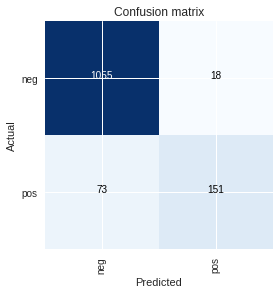

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
interp.plot_top_losses(4, figsize=(15,15))


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.savefig('/content/gdrive/My Drive/Cancer/data3/squeezenet_confusion_matrix.jpg')

In [0]:
k1 = data.valid_ds;k1

In [0]:
img = learn.data.valid_ds[0][0]

In [0]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [0]:
log_preds2,y = learn.pre()

In [0]:
log_preds

tensor([[3.5068e-01, 6.4932e-01],
        [3.2615e-02, 9.6738e-01],
        [5.0763e-01, 4.9237e-01],
        ...,
        [9.9920e-01, 7.9642e-04],
        [8.4543e-01, 1.5457e-01],
        [9.9456e-01, 5.4394e-03]])